# HOMEWORK 04

## Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$y = \frac{\theta_{1}\cdot x}{\theta_{2} + x}$$

a) Choose two suitable prior distributions for $\theta_1$ and $\theta_2$ and use HMC algorithm to find their posterior distributions, conditioning on the observations.

$x = (28, 55, 110, 138, 225, 375), \space \space \space y = (0.053, 0.060, 0.112, 0.105, 0.099, 0.122)$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from tabulate import tabulate
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [3]:
def model(x, distribution:dist, arg):
    
    """
    This function generate the model
    
    Parameters
    ----------
    x           : list
        it is a list of the independent values, 
        according the relationship between x and y
    distribution: pyro.distribution (dist)
        it is the distribution of the theta parameters 
        by which we are going to sample
    arg         : list of lists
        it is the list of elemntes for the distributions
        
    Returns
    -------
    obsorved output y
    """

    theta_1 = pyro.sample("theta_1", distribution(arg[0][0], arg[0][1]))
    theta_2 = pyro.sample("theta_2", distribution(arg[1][0], arg[1][1]))
    
    yhat = (theta_1*x)/(theta_2+x)
    y_data = pyro.sample("y_data", dist.Normal(yhat,1))
    
    return y_data

In [2]:
'''
Base case: it is used to check the right operation of the model
'''

x = torch.tensor([25, 55, 110, 138, 225, 375])
y = torch.tensor([0.053,0.060,0.112,0.105,0.099,0.122])

distribution = dist.Normal # or Exponential (in this case change param)
param = [[0, 1], [0, 1]]

cond_model = pyro.condition(model, data={"y_data": y})
result_1 = model(x, distribution, arg = param)
result_2 = cond_model(x, distribution, arg = param)

print("independent model result:", result_1)
print("conditioned model result:", result_2)

NameError: name 'model' is not defined

b) Discuss how different parameters for both priors and the HMC algorithm lead to different estimates.



1. discussion about the parameters for the priors

The given model fixes a clear relationship between 𝑥 and 𝑦, with the presence of the two parameters $𝜃_1$ and $𝜃_2$ (we may use $\theta = (\theta_{1}, \theta_{2})^{T}$); so, this relationship has to be seen us a constrain on the possible values assumed by our parameters. Moreover, 𝑥 and 𝑦 are observed and they lead to consider as suitable prior distributions, distributions that may offer real and positive values, as for example: a normal, a log-normal, an exponential or an inverse-gamma distribution for the two 𝜃. 

Under these assumptions, suppose to consider a normal distribution from which we obtain $𝜃_1 = 1$ and $𝜃_2 = 2$. They may satisfy our relation, but what might be happened if we consider an exponential distribution? Well, could be the case that they are not so good and this because we are changing the range of the parameters space. In conclusion, may exist other tuples satisfying the relationship, and so leading to a different estimates for our $\theta$.

2. discussion about the HMC algorithm's parameters

There are few parameters that manage the Markov Chain Algorithm: number of samples to mining, number of samples burned-in and number of chains; all of them are relevant to obtain a good approximation, so let's look them in more details.

__number of samples__

The number of samples represent the first of this triad and it is used to set the number of sampling operation that have to be done, in other words it's the length of the Markov Chain. So, greater is this value and more samples we are asking to the algorithm (and of course more precise will be our estimation).

__burn-in samples__

The burned-in samples is the second of the triad, and it is used to set the number of first samples that we have to discard; the reason behind this step is to avoid any dependency from the step zero, i.e. what is the first point chosen in the parameters space. In someway, this parameter is in opposite of the number of samples because it takes away a part of our samples, than we have to add this number to the total numebr of samples. Note, we have to take into account what is the samples size before any drop operation.

__number of chains__

This is the last element of our triad and it represents how many chains of the Markov Chain algorithm we are considering. Basically, it set the number of chains that are growing up during the procedure (hopefully, in parallel). The reason behind this decision is to restrict the bad results, i.e. those cases leading to a poor estimate and to improve the exploration phase in the parameters space.


Moreover, when we use this kind of algorithm it's a bad idea to set these parameters in a way that generate a huge number of samples, and this because it is very expensive in terms of computational power, space and time. Indeed, exist some indices and tools that may be useful in that sense.

As we have said at the beginning of this discussion, these parameters are very relevant for all MC algorithms and they have to be settled by choosing the best trade-off.

c) Plot the most reliable posterior distributions, according to convergence checks on the traces.

In [21]:
def mcmc_analysis(data, distr, arg, triad=[1000, 100, 3], detail=False):
    
    """
    This function perform the mcmc analysis on the model
    
    Parameters
    ----------
    data  : list of tensor
        it contains the knowen data, i.e. x and y
    distr : pyro.distribution
        it is the proposal distribution as prior distribution for theta
    arg   : list of lists
        it is the parameters for the distribution
    triad : list
        it is the triplet of the MC parameters
    detail: bool
        it is used to decide if show more information
        
    Returns
    -------
    neff         : integer
        the number of effective sample size
    mcmc_samples : dictionary
        the samples for the theta paramters
    """
    
    cond_model = pyro.condition(model, data={"y_data": data[1]})
    hmc_kernel = HMC(model=cond_model) # transition kernel
    mcmc = MCMC(hmc_kernel, num_samples=triad[0], 
                warmup_steps=triad[1], num_chains=triad[2])
    
    # posteriors and samples
    posterior = mcmc.run(data[0], distr, arg = arg)
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    
    mcmc.summary()

    if detail: # set it to "False" if you don't want to print other information
    
        keys = ["theta_1", "theta_2"]

        for key in keys:
            chains = mcmc_samples[key]

            n_chains, n_samples = chains.shape
            print(chains.shape)

            fig, ax = plt.subplots(1, n_chains, figsize=(12,3))
            for i, chain in enumerate(chains):
                sns.lineplot(x=range(n_samples), y=chain, ax=ax[i])
                ax[i].set_title("chain "+str(i+1))

        print("expected theta_1 =", mcmc_samples["theta_1"].mean().item())
        print("expected theta_2 =", mcmc_samples["theta_2"].mean().item())

        # plot
        fig, axes = plt.subplots(1, 2, figsize=(12,4))

        sns.distplot(mcmc_samples['theta_1'], ax=axes[0])
        axes[0].set_title('P( theta_1 | measurement=obs )')
        axes[0].set_xlabel('theta_1')

        sns.distplot(mcmc_samples['theta_2'], ax=axes[1])
        axes[1].set_title('P( theta_2 | measurement=obs )')
        axes[1].set_xlabel('theta_2')

        plt.show()
    
    print("diag:", mcmc.diagnostics())
    
    #extract the greater r_hat index between the two theta
    r_hat = [list(mcmc.diagnostics()['theta_1'].items())[1], 
             list(mcmc.diagnostics()['theta_2'].items())[1]]
    
    r_hat = max(r_hat)[1].item() # taken from the tuple
    
    if r_hat > 0.97 or r_hat <= 1.1: # establish the accept range (convergence)
        # store the lowest n_eff between the two theta
        neff = [list(mcmc.diagnostics()['theta_1'].items())[0], 
                list(mcmc.diagnostics()['theta_2'].items())[0]]
    
        neff = min(neff)[1].item() # it is extracted from the tuple
        
        return [neff, mcmc_samples]
    else: # this chain is divergent, so we can ignore it
        return [0, None]

In [7]:
'''
information on the model and MCMC paramters
'''

# observations
x = torch.tensor([25, 55, 110, 138, 225, 375])
y = torch.tensor([0.053,0.060,0.112,0.105,0.099,0.122])
data_xy = [x, y]

# MC triad
mc_param = [100, 10, 3]

In [22]:
'''
base case: it is used to show the operation analysis
'''

# candidate distribution and its arguments
distribution = dist.Normal
argument = [[0, 1], [0, 1]]

# mcmc analysis (we don't care about the return in this case)
tmp = mcmc_analysis(data_xy, distribution, argument, mc_param, False)





                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.07      0.37      0.10     -0.49      0.65    475.35      1.00
   theta_2     -0.60      0.28     -0.52     -1.11     -0.33     26.62      1.12

Number of divergences: 0
diag: {'theta_1': OrderedDict([('n_eff', tensor(475.3474)), ('r_hat', tensor(0.9992))]), 'theta_2': OrderedDict([('n_eff', tensor(26.6185)), ('r_hat', tensor(1.1158))]), 'divergences': {'chain 0': [], 'chain 1': [], 'chain 2': []}, 'acceptance rate': {'chain 0': 0.95, 'chain 1': 0.93, 'chain 2': 0.84}}


In [14]:
'''
searching for the most reliable posterior distributions
'''

# candidate distributions and their arguments
distribution = [dist.Normal, dist.Normal, 
                dist.Exponential, dist.InverseGamma]
argument = [[[0, 1], [0, 1]], [[1, 3], [1, 3]], 
            [[5, None], [5, None]], [[3, 0.5], [3, 0.5]]]

# repeat mcmc analysis for all these distributions
neff = None
for i in range(len(distribution)):
    tmp_neff, tmp_samples = mcmc_analysis(data_xy, distribution[i], 
                                          argument[i], mc_param)
    
    # we are basing on the n_eff to pick up 
    # the most reliable posterior distribution
    if neff is None or tmp_neff > neff: 
        neff = tmp_neff
        mcmc_samples = tmp_samples
        reliable = i
        
print("the most reliable distribution is:", distribution[reliable])
print("with parameters:", argument[reliable])





                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.08      0.37      0.08     -0.50      0.72   5699.94      1.00
   theta_2      0.01      1.00      0.02     -1.65      1.64   1402.29      1.00

Number of divergences: 0






                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.24      0.41      0.27     -0.42      0.92     22.78      1.08
   theta_2      1.05      2.98      1.07     -3.84      6.00   1906.26      1.00

Number of divergences: 0






                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.16      0.14      0.12      0.00      0.35   2846.40      1.00
   theta_2      0.21      0.21      0.15      0.00      0.49   1227.51      1.00

Number of divergences: 0






                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.20      0.12      0.17      0.06      0.36    532.96      1.01
   theta_2      0.25      0.23      0.18      0.06      0.46   1067.54      1.00

Number of divergences: 0
the most reliable distribution is: <class 'pyro.distributions.torch.Normal'>
with parameters: [[0, 1], [0, 1]]


## Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:

- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
  - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
  - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$
  
a) Supposing that samples are drawn from a bivariate normal distribution:
$$ {x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg], $$

implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

In [15]:
def conditional_dist(joint_mu, joint_cov, index, var):
    
    """
    This function compute the posterior conditioned 
    distribution for a bivariate normal distribution
    
    Parameters
    ----------
    joint_mu : list of real number
        it is the mean of the bivariate normal distribution
    joint_cov: covariance matrix
        it is the covariance matrix of the bivariate distribution
    index    : integer value choosen between 0 and 1
        it defines the parameter for which there is conditioning
    var      : real value
        it is the value assumed by "param[index]"
        
    Returns
    -------
    Normal distribution: N(mu, sigma)
    """
    
    mu_x = joint_mu[~index] # mu[0]
    mu_y = joint_mu[index] # mu[1]
    
    cov_x = joint_cov[~index][~index] # cov[0][0]
    cov_y = joint_cov[index][index]   # cov[1][1]
    cov_xy = joint_cov[~index][index] # cov[0][1]
    cov_yx = joint_cov[index][~index] # cov[1][0]
    
    inv_y = 1 / cov_y # cov[1][1] ^ (-1)
    
    mu = mu_x + cov_xy * inv_y * (var.item() - mu_y)
    sigma = cov_x - cov_xy * inv_y * cov_yx
    
    return dist.Normal(mu, sigma)

In [16]:
def gibbs_sampler(iters, warmup, mu=[0, 0], rho=0.7):
    
    """
    This function allows to sample according with the Gibbs Algorithm
    
    Parameters
    ----------
    iters : integer
        number of sampling that have to be perform
    warmup: integer
        number of first samples discarded
    mu    : list of real number
        mean of the bivariate normal distribution
    rho   : real number in the range [-1, 1]
        correlation coefficient between the parameters
        
    Returns
    -------
    list of samples
    """
    
    assert rho >= -1 and rho <= +1 # just to be sure...
    
    cov = [[1, rho], [rho, 1]]
    var_given = [0, 1] # index of the given variable: 0 = x_1, 1 = x_2
    
    samples = []
    x_1 = pyro.sample("x_1", dist.Normal(0, 1)) # start state
    
    for i in range(iters):
        # conditioned by x_1
        x_2 = pyro.sample("x_2", conditional_dist(mu, cov, var_given[0], x_1))
        # conditioned by x_2
        x_1 = pyro.sample("x_1", conditional_dist(mu, cov, var_given[1], x_2))
    
        samples.append([x_1.item(), x_2.item()]) # store the new state (x_1, x_2)
        
    return samples[warmup : ] # burn-in the first samples

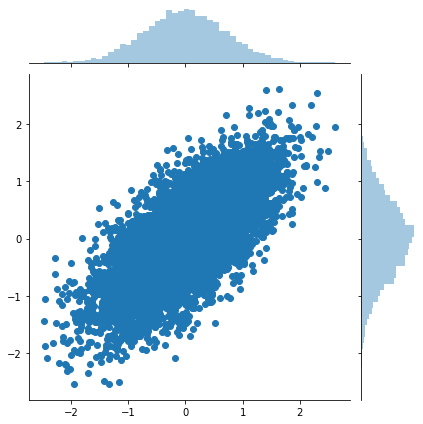

In [24]:
'''
Base case: it is used to show how works the Gibbs sampler
'''

samples = gibbs_sampler(iters = 10000, warmup = 1000)
samples

# plot
tlist = list(zip(*samples)) # convert sample columns in two tuples
#plt.plot(tlist[0], tlist[1]) # showing also the path...
sns.jointplot(tlist[0], tlist[1])

b) Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from Exercise 1.

theta_mu: [0.0833427342543275, 0.01229884534732749]
theta_rho: -0.001411008993062955
╒═════════╤═══════════╤═══════════╤══════════╤═════════╤════════════╤═════════════╕
│ Param   │      Mean │    Median │      Var │     Std │   Quant 5% │   Quant 95% │
╞═════════╪═══════════╪═══════════╪══════════╪═════════╪════════════╪═════════════╡
│ theta_1 │ 0.0769246 │ 0.0881518 │ 1.01669  │ 1.00831 │   -1.58005 │     1.72811 │
├─────────┼───────────┼───────────┼──────────┼─────────┼────────────┼─────────────┤
│ theta_2 │ 0.0195726 │ 0.0188603 │ 0.981863 │ 0.99089 │   -1.59986 │     1.65431 │
╘═════════╧═══════════╧═══════════╧══════════╧═════════╧════════════╧═════════════╛
corr-coef: -0.0122662269363362


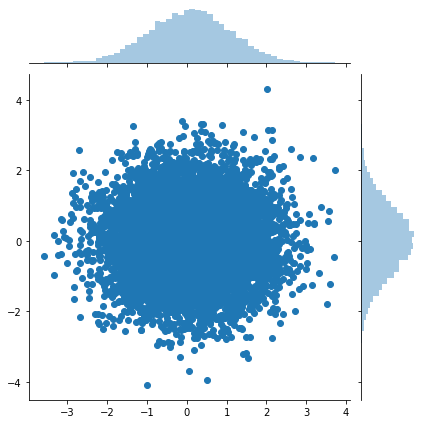

In [33]:
'''
inference on the theta parameters from the exercise 1
'''

# Suppose theta_1 and theta_2 with a bivariate normal distribution 
# as joint probability (i.e. how has been setted the gibbs_sampler).
# We can make some inference on these paramters.

# merge all the samples from different chains for both theta
theta_1 = [item.item() for sublist in mcmc_samples["theta_1"] for item in sublist]
theta_2 = [item.item() for sublist in mcmc_samples["theta_2"] for item in sublist]

# compute mean and correlation coeff
post_mu = [np.mean(theta_1), np.mean(theta_2)]
post_rho = np.corrcoef(theta_1, theta_2)[0][1]

# just to remember these values
print("theta_mu:", post_mu)
print("theta_rho:", post_rho)

samples = gibbs_sampler(mu = post_mu, rho = post_rho, iters = 10000, warmup = 1000)

#samples = gibbs_sampler(iters = 10000, warmup = 1000)
theta = list(zip(*samples)) 

# plot
sns.jointplot(theta[0], theta[1])

# and now?... Do some statistics!

# compute the given statistic function
stat = lambda fun, value: [fun(theta[i], value) for i in range(2)]

# statistic function and argument for each statistic
fnc = [np.mean, np.median, np.var, np.std, np.quantile, np.quantile]
val = [None, None, None, None, 0.05, 0.95]

# store statistics
name = [["theta_1", "theta_2"]]
statistics = name + [stat(fnc[i], val[i]) for i in range(len(fnc))]
corr = np.corrcoef(theta)[0][1]

# arrange nested list
t = list(zip(*statistics))
table = [t[0], t[1]]

head = ["Param", "Mean", "Median", "Var", "Std", "Quant 5%", "Quant 95%"]

# print in tabular format
print(tabulate(table, headers = head, tablefmt = "fancy_grid"))
print("corr-coef:", corr) # just to check...